In [19]:
import timeit

In [20]:
import time

In [21]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20, 6)
import pandas as pd
from pandas import datetime
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
#from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
#import pmdarima as pm
#from pmdarima.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import datetime
#from sklearn.linear_model import LinearRegressipo
from statsmodels.tsa.stattools import adfuller


/Users/maxmix/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  if __name__ == '__main__':


In [22]:
#import the data containing user behaviour while navigating the shop
df_monday= pd.read_csv('/Users/maxmix/Downloads/monday.csv', delimiter=';', index_col=0,  parse_dates=True)
df_monday

,customer_no,location
timestamp,,
2019-09-02 07:03:00,1,dairy
2019-09-02 07:03:00,2,dairy
2019-09-02 07:04:00,3,dairy
2019-09-02 07:04:00,4,dairy
2019-09-02 07:04:00,5,spices
...,...,...
2019-09-02 21:49:00,1442,checkout
2019-09-02 21:49:00,1444,checkout
2019-09-02 21:49:00,1445,dairy


Initial data exploration

In [23]:
#create variables hour
df_monday['hour'] = df_monday.index.hour

#create variables minute
df_monday["time"] = df_monday.index.time

#create variables day of the week
df_monday["day"] = df_monday.index.day_name()

#create variables daty
df_monday['date'] = df_monday.index.date

In [25]:
#Calculate the total number of customers in each section
df_monday.groupby(['location']).count()

,customer_no,hour,time,day,date
location,,,,,
checkout,1437,1437,1437,1437,1437
dairy,895,895,895,895,895
drinks,797,797,797,797,797
fruit,1005,1005,1005,1005,1005
spices,750,750,750,750,750


In [26]:
#Calculate the total number of customers in each section over time

# count all hourly visitors in the section dairy
df_monday_dairy= df_monday[(df_monday == 'dairy').any(axis=1)]
df_monday_dairy= df_monday_dairy.groupby(['hour']).count()

# count all hourly visitors in the section drinks
df_monday_drinks= df_monday[(df_monday == 'drinks').any(axis=1)]
df_monday_drinks=df_monday_drinks.groupby(['hour']).count()

# count all hourly visitors in the section fruits
df_monday_fruit= df_monday[(df_monday == 'fruit').any(axis=1)]
df_monday_fruit=df_monday_fruit.groupby(['hour']).count()

# count all hourly visitors in the section spices
df_monday_spices= df_monday[(df_monday == 'spices').any(axis=1)]
df_monday_spices= df_monday_spices.groupby(['hour']).count()

# count all hourly visitors in the section checkout
df_monday_checkout= df_monday[(df_monday == 'checkout').any(axis=1)]
df_monday_checkout=df_monday_checkout.groupby(['hour']).count()


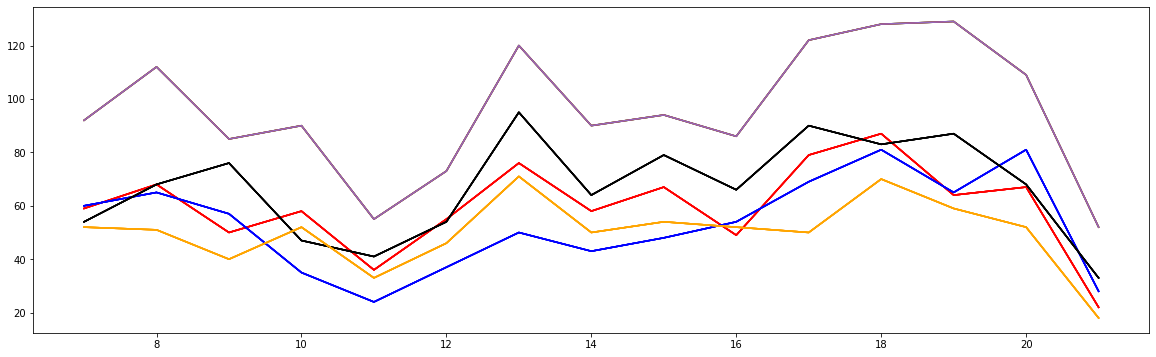

In [27]:
#plot them against each other to show customers being in each section during each hour of the day
plt.plot(df_monday_dairy, 'r')
plt.plot(df_monday_drinks, 'b')
plt.plot(df_monday_fruit, 'black')
plt.plot(df_monday_spices, 'orange')
plt.plot(df_monday_checkout)

<AxesSubplot:xlabel='hour'>

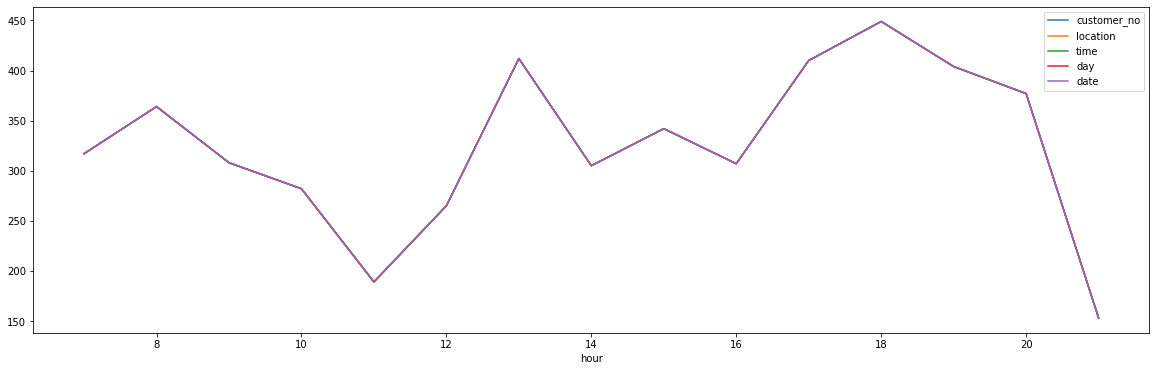

In [31]:
#how many custimers are in the shop every hour
df_monday.groupby(['hour']).count().plot()

In [29]:
#Calculate the time each customer spent in the market
#we take the most recent time stamp and the last one subtract the timestamp from each other and get the total time each customer spent in teh shop

timeinterval_for_each_customer=[]
for customer in df_monday['customer_no'].unique():
    df = df_monday[df_monday['customer_no'] == customer]
    #if a customer has no checkout we can assume he/she left at the closing time 22:00
    if len(df)==1:
        a = pd.to_datetime('2019-09-02 22:00:00') - df.head(1).index[0]
        timeinterval_for_each_customer.append(a)
    else:    
        a = df.tail(1).index[0] - df.head(1).index[0]
        timeinterval_for_each_customer.append( a)
#once we calculated the time spent for each customer we can create a dataframe cotaining all the time deltas
df_monday_up = pd.DataFrame (timeinterval_for_each_customer, columns = ['timedelta']) 
df_monday_up.reset_index(inplace= True)
df_monday_up['customer_n']=df_monday_up['index']+1
df_monday_up.drop(['index'], axis=1)

,timedelta,customer_n
0,0 days 00:02:00,1
1,0 days 00:03:00,2
2,0 days 00:02:00,3
3,0 days 00:04:00,4
4,0 days 00:01:00,5
...,...,...
1442,0 days 00:01:00,1443
1443,0 days 00:01:00,1444
1444,0 days 00:11:00,1445
1445,0 days 00:10:00,1446


Perform the Markov Chain analysis

In [33]:
df_monday

,customer_no,location,hour,time,day,date
timestamp,,,,,,
2019-09-02 07:03:00,1,dairy,7,07:03:00,Monday,2019-09-02
2019-09-02 07:03:00,2,dairy,7,07:03:00,Monday,2019-09-02
2019-09-02 07:04:00,3,dairy,7,07:04:00,Monday,2019-09-02
2019-09-02 07:04:00,4,dairy,7,07:04:00,Monday,2019-09-02
2019-09-02 07:04:00,5,spices,7,07:04:00,Monday,2019-09-02
...,...,...,...,...,...,...
2019-09-02 21:49:00,1442,checkout,21,21:49:00,Monday,2019-09-02
2019-09-02 21:49:00,1444,checkout,21,21:49:00,Monday,2019-09-02
2019-09-02 21:49:00,1445,dairy,21,21:49:00,Monday,2019-09-02


the last customer do not have the checkout stamp. the shop closes at 22:00. let's add the checkout for all customers if not present at time 22:00

In [100]:
def add_missing_customer_checkout(df_monday):
    
    #let's get all the customers and check if they have the checkout location
    customer_no = df_monday['customer_no'].unique()
    for id in customer_no:
        customer_df = df_monday[df_monday['customer_no']==id]
        #if they have it, all is goo
        if 'checkout' in customer_df['location'].values:
            pass
        #othervise let's add it at the end
        else:
            checkout_dict = {'customer_no':id, 'location':'checkout', 'hour':'22',  
                             'time':'22:00:00', 'day':'Monday', 'date':'2019-09-02'}
            df_monday = df_monday.append(checkout_dict, ignore_index=True)
    return df_monday

In [35]:
#execute formula
full_df = add_missing_customer_checkout(df_monday)


1430
1433
1437
1439
1440
1441
1443
1445
1446
1447


In [ ]:
#add datetime to the dataframe
full_df['datetime']=pd.to_datetime(full_df['date'].astype(str) + ' ' + full_df['time'].astype(str))

In [36]:
full_df

,customer_no,location,hour,time,day,date,datetime
0,1,dairy,7,07:03:00,Monday,2019-09-02,2019-09-02 07:03:00
1,2,dairy,7,07:03:00,Monday,2019-09-02,2019-09-02 07:03:00
2,3,dairy,7,07:04:00,Monday,2019-09-02,2019-09-02 07:04:00
3,4,dairy,7,07:04:00,Monday,2019-09-02,2019-09-02 07:04:00
4,5,spices,7,07:04:00,Monday,2019-09-02,2019-09-02 07:04:00
...,...,...,...,...,...,...,...
4889,1441,checkout,22,22:00:00,Monday,2019-09-02,2019-09-02 22:00:00
4890,1443,checkout,22,22:00:00,Monday,2019-09-02,2019-09-02 22:00:00
4891,1445,checkout,22,22:00:00,Monday,2019-09-02,2019-09-02 22:00:00
4892,1446,checkout,22,22:00:00,Monday,2019-09-02,2019-09-02 22:00:00


In [37]:
#we need the dataset with a granularity of 1 minute intervals. the next code is to create that new df
#let's take the structure of the full_df
new_df=full_df.iloc[[0]][:0]
#for each customer set the timestamp as datime and as index
for customer in full_df['customer_no'].unique():
    df = full_df[full_df['customer_no'] == customer]
    pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)
    #create all rows with the missing minute for a every-minute listing and fill the location value with the previous location
    df=df.resample('1T').ffill()
    new_df=new_df.append(df)
full_filled_df=new_df    


In [43]:
full_filled_df

,customer_no,location,hour,time,day,date,datetime
2019-09-02 07:03:00,1,dairy,7,07:03:00,Monday,2019-09-02,NaT
2019-09-02 07:04:00,1,dairy,7,07:03:00,Monday,2019-09-02,NaT
2019-09-02 07:05:00,1,checkout,7,07:05:00,Monday,2019-09-02,NaT
2019-09-02 07:03:00,2,dairy,7,07:03:00,Monday,2019-09-02,NaT
2019-09-02 07:04:00,2,dairy,7,07:03:00,Monday,2019-09-02,NaT
...,...,...,...,...,...,...,...
2019-09-02 21:56:00,1447,fruit,21,21:50:00,Monday,2019-09-02,NaT
2019-09-02 21:57:00,1447,fruit,21,21:50:00,Monday,2019-09-02,NaT
2019-09-02 21:58:00,1447,fruit,21,21:50:00,Monday,2019-09-02,NaT
2019-09-02 21:59:00,1447,fruit,21,21:50:00,Monday,2019-09-02,NaT


we need now a table specifieing for each customer where this induvidul was in a specific timestamp and whitch was the location he/she visited next

In [47]:
#i wrote a formula that will create a dataframe for every min for every customer with current location and previous one
def get_first_and_sec_location(df_monday):
    empty_list=[]
    for customer_no in df_monday['customer_no'].unique():
        df = df_monday[df_monday['customer_no'] == customer_no]
        if len(df) > 1:
            _=0
            while _ < (len(df)-1):
                x=[]
                x.append(str(customer_no))
                x.append(df['location'][_])
                x.append(df['location'][_+1])
                _+=1
                empty_list.append(x)
    df_monday_up_2 = pd.DataFrame(empty_list, columns = ['customer_no', 'section_1', 'section_2'])
    return(df_monday_up_2)

In [102]:
df_monday_up_2=get_first_and_sec_location(full_filled_df)

,customer_no,section_1,section_2
0,1,dairy,dairy
1,1,dairy,checkout
2,2,dairy,dairy
3,2,dairy,dairy
4,2,dairy,checkout
...,...,...,...
9427,1447,fruit,fruit
9428,1447,fruit,fruit
9429,1447,fruit,fruit
9430,1447,fruit,fruit


In [49]:
df_monday['customer_no'].value_counts().idxmax()

526

In [103]:
#aggregate the created list according to location resulting into a matrix
df_monday_up_2.groupby(['section_2']).count()

,customer_no,section_1
section_2,,
checkout,1447,1447
dairy,3125,3125
drinks,1815,1815
fruit,2080,2080
spices,965,965


In [51]:
df_monday_up_2.groupby(['section_1']).count()

,customer_no,section_2
section_1,,
dairy,3537,3537
drinks,2047,2047
fruit,2600,2600
spices,1248,1248


In [52]:
#cross put into reference the previous and current section into a new matrix
crosstab=pd.crosstab(df_monday_up_2['section_1'], df_monday_up_2['section_2'], normalize=0)

In [56]:
crosstab

section_2,checkout,dairy,drinks,fruit,spices
section_1,,,,,
dairy,0.088776,0.746961,0.061634,0.050891,0.051739
drinks,0.208109,0.011236,0.610650,0.090865,0.079140
fruit,0.203077,0.086538,0.050000,0.613462,0.046923
spices,0.143429,0.188301,0.173878,0.095353,0.399038


In [53]:
#cross put into reference the previous and current section into a new matrix as numpy array

probability_matrix=pd.crosstab(df_monday_up_2['section_1'], df_monday_up_2['section_2'], normalize=0).to_numpy()

In [105]:
#since the checkout has no follow up section we created a 5x4 matrix. to make it symmetric we added a null row rappresenting the checkout section. basically you can't go anywhere else from the checkout
#the values in this matrix reppresent the probability of your next location
newrow = [0,0,0,0,0]
probability_matrix = np.vstack([probability_matrix, newrow])

# CLASSES

I created two classes "Customer" and "Game". "Customer" descrives the game mechanics, level design and basic set up. The class "Game" is more functional, and is used to make the game start, count score and initialize a new playthrough. 

In [291]:
class Customer:
    """
    a single customer that moves through the supermarket
    in a MC simulation
    """
    def __init__(self, name, state, transition_probs, budget=100, points=0, lives=3, highscore=0):
        self.name = name
        self.state = state
        self.budget = budget
        self.transition_probs= transition_probs
        self.points= points
        self.lives= lives
        self.highscore=highscore
    
    def __repr__(self):
        return f'<Customer {self.name} is in {self.state}>'
    
    #location of the players. it can be death, checkout, diary, drinks,fruits, spices
    def where(self):
        #deaths ends the game -1 life
        if self.state == 'death':
            return f'<You are bleading to {self.state} my dear {self.name}. Pikachu attacked you with a knife >'
        
        #if the player is not dead or in checkout he has to spin the weel again and see go to the next location
        elif self.state != 'checkout':
            return f'<{self.name} you are in the {self.state} section. safe for now... >'
        #checkout ends game, no life subtraction, ironically remembering you that you forgot to buy the milk, you'll have to go back...
        else:
            return f'<{self.state}!!! You made it {self.name}, congrats. You got the milk right? Right?!?... >'
    
    #if pikachu and the player are in the same location, pikachu will attack (with a knife, lol)
    def attack(self):
        return f'<{self.name} attacks you with a knife>'
    
    #
    def next_state(self):
        if self.budget != 0:
            time.sleep(0.5)
            '''
            Propagates the customer to the next state according the probability calculated in the markov chain model.
            Returns nothing.
            '''
            #if player in spices he will be sent to...
            if self.state == 'spices':
                self.state = np.random.choice(['checkout','dairy','drinks','fruit','spices'], p=self.transition_probs[3])
                return f'<{self.name} you are in the {self.state} section and safe for now... >'
            
            #if player in dairy he will be sent to...    
            elif self.state == 'dairy':
                self.state = np.random.choice(['checkout','dairy','drinks','fruit','spices'], p=self.transition_probs[0])
                return f'<{self.name} you are in the {self.state} section and safe for now... >'

            #if drinks in spices he will be sent to...
            elif self.state == 'drinks':
                self.state = np.random.choice(['checkout','dairy','drinks','fruit','spices'], p=self.transition_probs[1])
                return f'<{self.name} you are in the {self.state} section and safe for now... >'

            #if fruits in spices he will be sent to...
            else :
                self.state = np.random.choice(['checkout','dairy','drinks','fruit','spices'], p=self.transition_probs[2])
                return f'<{self.name} you are in the {self.state} section and safe for now... >'
        
        #this was incorporated with the intetion to potentially expand the game and give players the possibility to turn into hunters themselves
        else:  
            self.next_state_P()
   
    #this was included for future expansions    
    def is_active(self):
        if self.state == 'checkout':
            return('False')
        else:
            self.budget=0
            self.pikachu_activate()

    #this was included for future expansions with the idea to activate or disactivate the hunter figure. was kept for commedic purpose    
    def pikachu_activate(self):
        if self.name== 'pikachu':
            budget=0                    
        return f'<{self.name} is getting staby...>'
    #restart the game
    def restart(self):
        self.highscore=[]
  
    #returns the score
    def score(self):   
        if player.highscore == 0:
            return(0)
        else:
            return(sum(player.highscore))

    # these are the movements of the hunter pikachu. he uses a random movement pattern
    def next_state_P(self):
        if self.state == 'spices':
            self.state = np.random.choice(['dairy','drinks','fruit','spices'], p=[0.25,0.25,0.25,0.25,])
        elif self.state == 'dairy':
            self.state = np.random.choice(['dairy','drinks','fruit','spices'], p=[0.25,0.25,0.25,0.25,])
        elif self.state == 'drinks':
            self.state = np.random.choice(['dairy','drinks','fruit','spices'], p=[0.25,0.25,0.25,0.25,])
        else:
            self.state = np.random.choice(['dairy','drinks','fruit','spices'], p=[0.25,0.25,0.25,0.25,])

In [329]:
class Game:
    """
    basic rules of the game, including score, start and interface
    """
    def __init__(self, name , status='OVER', lives=3, ingame_score=[]):
        self.name= name
        self.status = status
        self.lives =  lives
        self.ingame_score= ingame_score
       
        
    
    def __repr__(self):
        return f'<The game is {self.status}>'
    
    #start game
    def start(self):
        self.check_active()
        return(self.check_active())
    
    #set up a new game
    def new_game(self):
        self.lives=3
        self.ingame_score=[]
        
    # tells when the game is over
    def check_active(self):
        if self.lives > 0:
            self.status = 'ON'
        else:
            self.status = 'OVER'
        return f'<The game is {self.status}>'


    def ingame_score(self):
        self.ingame_score=[]

        
    
      

In [338]:
'''
This is the actual game. it recalls the classes. 
The player moves around according to the markov chain and pikachu moves according to ramdom chance.
If they end up in the same location the player loses a life. 
For every location the players visits he will get 1000 points. and if he manages to reach teh check out he will multiply his current score by 10.
Pikachu can't reach the check out. '''
#initialization of the game. score=0
def game_1(player, game1, pikachu):
    game1.start()
    #check if the game has already stated
    if game1.status =='ON':
        player.points=0

        #print text
        print(pikachu.pikachu_activate())

        #activate player and print location
        player.state=np.random.choice(['dairy','drinks','fruit','spices'])
    

        #if the player meets pikachu he loses a life
        while player.state   in ['dairy','drinks','fruit','spices']: #!= 'checkout':
            if player.state== pikachu.state:
                player.state = 'death'
                game1.lives -=1
        #if he doen't meet him, he will get 1000 points        
            else:    
                print(player.where())
                player.next_state()
                pikachu.next_state()
                player.points +=1000


        print(player.where())

        #player multiplies his current score by 10 if he reaches checkout
        if player.state == 'checkout':
            score= player.points*10

        #othervise he loses one life
        else:
            score= player.points
        print('current lives ',game1.lives) 
        game1.ingame_score.append(score)

    #if the player has no more lifes, he can't play anymore
    else:
        print(game1.start())
        score=0
    print('your score is ' , score)
    player.highscore=game1.ingame_score
    print('your total score is: ', player.score())
    print(game1.start())

In [339]:
#let's create the pikachu
pikachu = Customer("pikachu", "dairy",probability_matrix, 0)

In [340]:
#and the player, I called him Ash and he will start from the dairy location
player = Customer("Ash", "dairy",probability_matrix, 100)

In [341]:
#we also have to create a game
game1 = Game('OutRunPikachu')

# Game

In [360]:
#let's start the game
game1.new_game()

In [361]:
game_1(player, game1, pikachu)

<pikachu is getting staby...>
<Ash you are in the spices section. safe for now... >
<Ash you are in the spices section. safe for now... >
<Ash you are in the spices section. safe for now... >
<checkout!!! You made it Ash, congrats. You got the milk right? Right?!?... >
current lives  3
your score is  30000
your total score is:  30000
<The game is ON>


In [362]:
game_1(player, game1, pikachu)

<pikachu is getting staby...>
<Ash you are in the drinks section. safe for now... >
<Ash you are in the drinks section. safe for now... >
<Ash you are in the drinks section. safe for now... >
<checkout!!! You made it Ash, congrats. You got the milk right? Right?!?... >
current lives  3
your score is  30000
your total score is:  60000
<The game is ON>


In [363]:
game_1(player, game1, pikachu)

<pikachu is getting staby...>
<Ash you are in the dairy section. safe for now... >
<Ash you are in the drinks section. safe for now... >
<You are bleading to death my dear Ash. Pikachu attacked you with a knife >
current lives  2
your score is  2000
your total score is:  62000
<The game is ON>


In [364]:
game_1(player, game1, pikachu)

<pikachu is getting staby...>
<Ash you are in the spices section. safe for now... >
<Ash you are in the drinks section. safe for now... >
<Ash you are in the drinks section. safe for now... >
<Ash you are in the fruit section. safe for now... >
<Ash you are in the dairy section. safe for now... >
<Ash you are in the dairy section. safe for now... >
<Ash you are in the dairy section. safe for now... >
<You are bleading to death my dear Ash. Pikachu attacked you with a knife >
current lives  1
your score is  7000
your total score is:  69000
<The game is ON>


In [365]:
game_1(player, game1, pikachu)

<pikachu is getting staby...>
<Ash you are in the spices section. safe for now... >
<Ash you are in the spices section. safe for now... >
<Ash you are in the dairy section. safe for now... >
<You are bleading to death my dear Ash. Pikachu attacked you with a knife >
current lives  0
your score is  3000
your total score is:  72000
<The game is OVER>


In [366]:
game1.new_game()

In [367]:
game_1(player, game1, pikachu)

<pikachu is getting staby...>
<Ash you are in the spices section. safe for now... >
<checkout!!! You made it Ash, congrats. You got the milk right? Right?!?... >
current lives  3
your score is  10000
your total score is:  10000
<The game is ON>
